In [ ]:
# --- Data Cleaning Process ---
# all_reviews_cleaning.py

import pandas as pd
import numpy as np
import re

# Load dataset
df = pd.read_csv("/Users/Srinija/Documents/2025_spring_classes/AIT582-DL1/project/all_reviews.csv", encoding="utf-8")

# Step 1: Standardize column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Step 2: Handle numerical columns
numerical_cols = [
    'rating', 'career_opportunities', 'compensation_and_benefits',
    'senior_management', 'work/life_balance', 'culture_&_values', 'diversity_&_inclusion'
]

for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

# Step 3: Handle categorical columns
categorical_cols = ['title', 'status', 'pros', 'cons', 'recommend', 'ceo_approval', 'business_outlook','job']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        if df[col].isnull().sum() < 0.5 * len(df):
            df[col] = df[col].fillna(df[col].mode()[0])

# Step 4: Fix flag mappings
flag_map = {'v': 'Yes', 'x': 'No', 'o': 'Neutral', 'V': 'Yes', 'X': 'No', 'O': 'Neutral'}
outlook_map = {'v': 'Positive', 'x': 'Negative', 'o': 'Neutral'}

df['recommended'] = df['recommend'].map(flag_map)
df['ceo_approved'] = df['ceo_approval'].map(flag_map)
df['business_outlook_clean'] = df['business_outlook'].map(outlook_map)

# Step 5: Parse and convert date
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['year'] = df['date'].dt.year

# Step 6: Derive new columns

# Rating category
df['rating_category'] = pd.cut(
    df['rating'],
    bins=[0, 1.5, 2.5, 3.5, 4.5, 5.1],
    labels=['Very Poor', 'Poor', 'Average', 'Good', 'Excellent']
)

# Employment status
df['employment_status'] = df['status'].str.extract(r'(Current|Former)', expand=False)

# Employment duration
def extract_duration(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'(less than 1 year|1 to 3 years|3 to 5 years|5 to 7 years|7 to 10 years|more than 10 years)', str(text))
    return match.group(1) if match else np.nan

df['employment_duration'] = df['status'].apply(extract_duration)

# Step 7: Clean text columns
text_cols = ['pros', 'cons', 'title']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Step 8: Extract the company name from the firm link
def extract_company_name(url):
    # Pattern to match text between 'Reviews/' and '-Reviews'
    pattern = r'Reviews/(.*?)-Reviews'
    match = re.search(pattern, url)
    
    if match:
        return match.group(1)
    else:
        return None

def replace_dash(url):
    company = url.replace("-"," ")
    return company

df['company_name'] = df['firm_link'].apply(extract_company_name)
df.drop(columns=['firm_link'], inplace=True)# Save results
df['company name'] = df['company_name'].apply(replace_dash)
df.drop(columns=['company_name'], inplace=True)# Save results

# Step 9: Final cleanup – drop unneeded original flags
df.drop(columns=['recommend', 'ceo_approval', 'business_outlook'], inplace=True, errors='ignore')

# Step 10: Reorder columns for analysis
desired_order = [
    'job','company name','title', 'date', 'year', 'rating', 'rating_category', 'recommended',
    'ceo_approved', 'business_outlook_clean', 'employment_status', 'employment_duration',
    'pros', 'cons'
] + [col for col in numerical_cols if col in df.columns]

df = df[[col for col in desired_order if col in df.columns]]
print(df.head(20))
# Step 10: Save cleaned dataset
df.to_csv("cleaned_reviews_final.csv", index=False)
print("Cleaned dataset saved as 'cleaned_reviews_final.csv'")


In [ ]:
# --- Exploratory Data Analysis ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("/Users/jammibhargavi/Downloads/cleaned_reviews_final (1).csv")

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe(include='all'))

# Ensure the column names (after cleaning) are as expected:
print("\nColumns in DataFrame:")
print(df.columns.tolist())

# -----------------------------------------------------------
# Prepare numerical and categorical columns for analysis
# -----------------------------------------------------------

# The numerical columns from your cleaning script are:
numerical_cols = [
    'rating', 
    'career_opportunities', 
    'compensation_and_benefits',
    'senior_management', 
    'work/life_balance',      # Note: This column is named exactly as in the cleaning script.
    'culture_&_values', 
    'diversity_&_inclusion'
]

# If a column does not exist (e.g., due to naming issues), check and adjust accordingly:
existing_num_cols = [col for col in numerical_cols if col in df.columns]
print("\nNumerical Columns Used for Analysis:")
print(existing_num_cols)

# For categorical columns, we consider these:
categorical_cols = ['recommended', 'ceo_approved', 'business_outlook_clean', 'employment_status', 'rating_category']

# -----------------------------------------------------------
# Correlation Analysis: Heatmap for numerical features
# -----------------------------------------------------------
# Calculate the correlation matrix for the available numerical columns
corr_matrix = df[existing_num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap for Numerical Rating Columns")
plt.tight_layout()
plt.show()

# Interpretation:
# - Look for strong positive (near +1) or negative (near -1) correlations between features.
# - For example, if 'compensation_and_benefits' correlates highly with 'rating', that suggests employees’ overall satisfaction
#   may be strongly influenced by compensation.

# -----------------------------------------------------------
# Box Plots: Distribution of numerical features by rating_category
# -----------------------------------------------------------
# Check that 'rating_category' exists. It was created during cleaning.
if 'rating_category' in df.columns:
    for col in existing_num_cols:
        if col != 'rating':  # Skip if you want to avoid redundant plots (e.g., overall rating itself)
            plt.figure()
            sns.boxplot(data=df, x='rating_category', y=col, palette="Set2")
            plt.title(f"Box Plot of {col.replace('_', ' ').title()} by Rating Category")
            plt.xlabel("Rating Category")
            plt.ylabel(col.replace("_", " ").title())
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
# Interpretation:
# - Box plots reveal the median, interquartile range, and potential outliers.
# - Compare how each rating aspect (like 'work/life_balance') changes across rating categories.
    
# -----------------------------------------------------------
# Distribution Plots: Histograms for numerical features
# -----------------------------------------------------------
for col in existing_num_cols:
    plt.figure()
    sns.histplot(df[col], kde=True, color="skyblue")
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
# Interpretation:
# - Histograms (with KDE overlay) help you see how each feature is distributed.
# - Check for skewness (e.g., a concentration of scores near 4 or 5) or the presence of multiple peaks.

# -----------------------------------------------------------
# Count Plots: For key categorical variables
# -----------------------------------------------------------
for col in categorical_cols:
    if col in df.columns:
        plt.figure()
        sns.countplot(data=df, x=col, palette='pastel')
        plt.title(f"Count Plot for {col.replace('_', ' ').title()}")
        plt.xlabel(col.replace("_", " ").title())
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
# Interpretation:
# - Count plots help assess the balance or skew in categorical variables.
# - For example, if the count for 'recommended' shows a high proportion of 'Yes' compared to 'No' or 'Neutral',
#   this could indicate general employee satisfaction regarding recommendations.

# -----------------------------------------------------------
# Additional Analysis: Grouped Means for burnout proxies (if applicable)
# -----------------------------------------------------------
# If you have engineered additional burnout proxy features (e.g., a numeric version of recommendations), you can analyze them grouped by rating_category.
# For example, if you want to convert 'recommended' (categorical) into a numeric representation:
if 'recommended' in df.columns:
    # Mapping: 'Yes' -> 1, 'Neutral' -> 0.5, 'No' -> 0 (adjust mapping as appropriate)
    mapping = {"Yes": 1, "Neutral": 0.5, "No": 0}
    df['recommended_numeric'] = df['recommended'].map(mapping)
    
    burnout_proxies = ['work/life_balance', 'recommended_numeric']
    # Check if both columns exist
    burnout_proxies = [col for col in burnout_proxies if col in df.columns]
    
    if 'rating_category' in df.columns and burnout_proxies:
        grouped_means = df.groupby('rating_category')[burnout_proxies].mean()
        print("\nGrouped Means by Rating Category:")
        print(grouped_means)
# Interpretation:
# - This section helps you see how proxy measures (like numeric recommendation scores and work/life_balance)
#   vary across different rating categories, offering insight into burnout trends.

# End of EDA Script


# Burnout Classification Analysis
Step‑by‑step pipeline with separate cells for data loading, preprocessing, feature engineering, and model training.

## 1. Data Loading
Load the cleaned reviews dataset and take a sample for analysis.

In [1]:
import pandas as pd

# --------------------------
# Step 1: Load and Sample Data
# --------------------------
df = pd.read_csv('/Users/jammibhargavi/Downloads/cleaned_reviews_final (1).csv').sample(20000, random_state=42)
df.head()

,job,company name,title,date,year,rating,rating_category,recommended,ceo_approved,business_outlook_clean,...,employment_duration,pros,cons,rating.1,career_opportunities,compensation_and_benefits,senior_management,work/life_balance,culture_&_values,diversity_&_inclusion
987230,Executive Quality Assurance Assistant,Nestl%C3%A9,quality assurance,2017-06-19,2017.0,4.0,Good,Yes,Yes,Neutral,...,less than 1 year,"international experience, multicultural team, ...","busy schedule of the team, career website is n...",4.0,4.0,2.0,3.0,5.0,5.0,4.0
79954,NaN,Netcall,experience working here very negative,2016-09-14,2016.0,1.0,Very Poor,No,No,Negative,...,NaN,there are no pros in my experience working her...,outdated sales practices - by about 20 years\n...,1.0,1.0,1.0,1.0,2.0,1.0,4.0
567130,Credit Modeler,Radian Group,great place to work,2022-04-15,2022.0,5.0,Excellent,Neutral,Neutral,Neutral,...,NaN,great work life balance and manager,work is independent and not many team meetings...,5.0,3.0,3.0,3.0,3.0,4.0,4.0
500891,Anonymous Employee,Taco Bell,great company,2022-05-05,2022.0,5.0,Excellent,Neutral,Neutral,Neutral,...,NaN,full of powerful individuals with passion.,quite a little bit pressuring to work and meet...,5.0,3.0,3.0,3.0,3.0,4.0,4.0
55399,Sales Associate,Ross Stores,sales associate,2015-10-16,2015.0,3.0,Average,Yes,NaN,Positive,...,less than 1 year,flexible hours\r\neasy job\r\nmostly nice co-w...,some managers they hire aren't really what ros...,3.0,5.0,2.0,3.0,3.0,4.0,4.0


## 2. Text Cleaning & Sentiment Analysis
Clean text and compute VADER sentiment scores for 'pros' and 'cons'.

In [4]:
import nltk, re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords')
nltk.download('vader_lexicon')
stop_words = stopwords.words('english')
analyzer = SentimentIntensityAnalyzer()

def clean_text(text):
    return re.sub(r'[^\w\s]', '', str(text).lower())

for col in ['pros', 'cons']:
    df[col] = df[col].fillna("")
    df[f"{col}_clean"] = df[col].apply(clean_text)
    df[f"{col}_sentiment"] = df[col].apply(lambda x: analyzer.polarity_scores(x)['compound'])

df[['pros_clean','pros_sentiment','cons_clean','cons_sentiment']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jammibhargavi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jammibhargavi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,pros_clean,pros_sentiment,cons_clean,cons_sentiment
987230,international experience multicultural team pr...,0.6369,busy schedule of the team career website is no...,-0.0762
79954,there are no pros in my experience working her...,-0.5267,outdated sales practices by about 20 years\no...,-0.4404
567130,great work life balance and manager,0.6249,work is independent and not many team meetings...,0.0000
500891,full of powerful individuals with passion,0.7003,quite a little bit pressuring to work and meet...,-0.3368
55399,flexible hours\r\neasy job\r\nmostly nice cowo...,0.7650,some managers they hire arent really what ross...,0.0000


## 3. Topic Modeling
Extract dominant topics via LDA.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words=stop_words, max_df=0.95, min_df=10, max_features=3000)
X_text = vectorizer.fit_transform(df['cons_clean'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_dist = lda.fit_transform(X_text)
df['dominant_topic'] = topic_dist.argmax(axis=1) + 1
df[['dominant_topic']].head()

,dominant_topic
987230,4
79954,2
567130,1
500891,2
55399,3


## 4. Label Creation & Original Features

In [8]:
from sklearn.preprocessing import LabelEncoder

def label_burnout(r):
    if r <= 2: return "High"
    elif r == 3: return "Moderate"
    else: return "Low"

df['burnout_label'] = df['rating'].apply(label_burnout)
original_features = ['rating','pros_sentiment','cons_sentiment','dominant_topic']
X_orig = df[original_features]
y = LabelEncoder().fit_transform(df['burnout_label'])
X_orig.head()

,rating,pros_sentiment,cons_sentiment,dominant_topic
987230,4.0,0.6369,-0.0762,4
79954,1.0,-0.5267,-0.4404,2
567130,5.0,0.6249,0.0000,1
500891,5.0,0.7003,-0.3368,2
55399,3.0,0.7650,0.0000,3


## 5. Original Models Training

SVM report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00      2242
           2       1.00      1.00      1.00       925

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

RF report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00      2242
           2       1.00      1.00      1.00       925

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000

NB report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       833
           1       1.00      1.00      1.00      2242
           2       1.00      1.00      1.

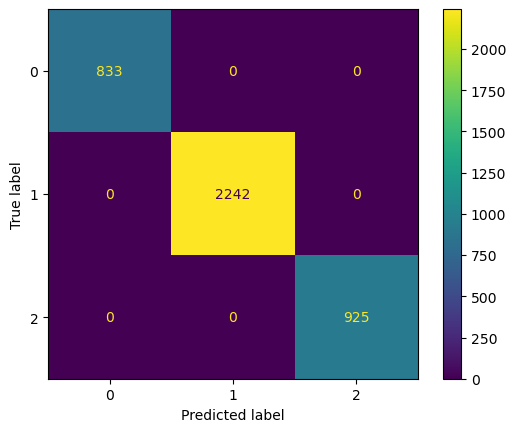

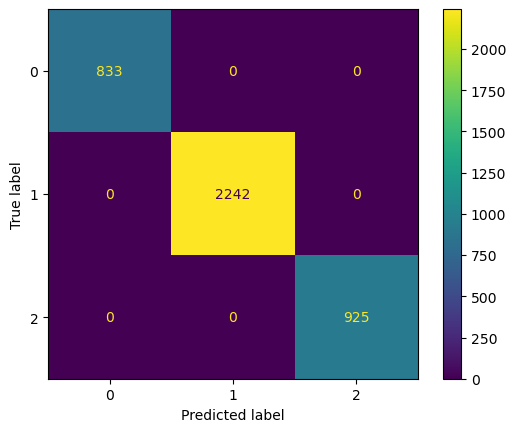

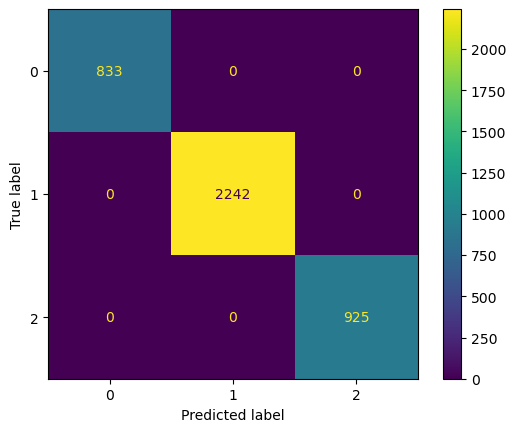

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

X_tr, X_te, y_tr, y_te = train_test_split(X_orig, y, test_size=0.2, random_state=42, stratify=y)

models = {
    'SVM': (SVC(),{'C':[0.1,1,10],'kernel':['linear','rbf']}),
    'RF': (RandomForestClassifier(random_state=42),{'n_estimators':[100],'max_depth':[None]}),
    'NB': (GaussianNB(),{})
}

for name,(clf,params) in models.items():
    if params:
        grid = GridSearchCV(clf, params, cv=5)
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_
    else:
        best = clf.fit(X_tr, y_tr)
    pred = best.predict(X_te)
    print(f"{name} report:")
    print(classification_report(y_te, pred))
    ConfusionMatrixDisplay.from_predictions(y_te, pred)

## 6. Enhanced Features: TF-IDF & Full Topic Distributions

In [17]:
# — Cell 6: Enhanced Features: TF‑IDF & Full Topic Distributions — 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing         import StandardScaler
from imblearn.over_sampling        import SMOTE
from sklearn.preprocessing         import LabelEncoder

# 1. TF‑IDF on cleaned “cons”
tfidf = TfidfVectorizer(stop_words=stop_words, max_features=2000)
X_tfidf = tfidf.fit_transform(df['cons_clean'])

# 2. Assemble your feature DataFrame
features_df = pd.DataFrame(X_tfidf.toarray())
for i in range(topic_dist.shape[1]):
    features_df[f"topic_{i}"] = topic_dist[:, i]
features_df['pros_sentiment'] = df['pros_sentiment']
features_df['cons_sentiment'] = df['cons_sentiment']
features_df['work_life']       = df['work/life_balance']
features_df['comp']            = df['compensation_and_benefits']

# 3. Drop ANY rows with missing values (NaNs) and sync target
clean_idx    = features_df.dropna().index
features_df  = features_df.loc[clean_idx]
y_clean      = LabelEncoder().fit_transform(df.loc[clean_idx, 'burnout_label'])

# 4. All column names must be strings (for newer sklearn versions)
features_df.columns = features_df.columns.astype(str)

# 5. Scale
scaler  = StandardScaler()
X_enh   = scaler.fit_transform(features_df)

# 6. SMOTE on the cleaned, scaled data
X_res, y_res = SMOTE(random_state=42).fit_resample(X_enh, y_clean)

# Now proceed with model training in the next cell


## 7. Enhanced Models Training & Evaluation

SVM best: {'C': 10, 'kernel': 'rbf'}
SVM enhanced report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.80      0.76      0.78        42
           2       0.83      0.83      0.83        42

    accuracy                           0.83       125
   macro avg       0.83      0.83      0.83       125
weighted avg       0.83      0.83      0.83       125

RF best: {'max_depth': None, 'n_estimators': 100}
RF enhanced report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        41
           1       0.64      0.88      0.74        42
           2       0.82      0.55      0.66        42

    accuracy                           0.75       125
   macro avg       0.78      0.75      0.75       125
weighted avg       0.78      0.75      0.75       125

NB enhanced report:
              precision    recall  f1-score   support

           0       0.65      0.90  

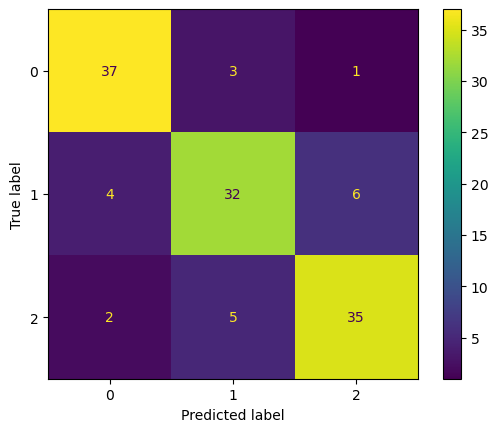

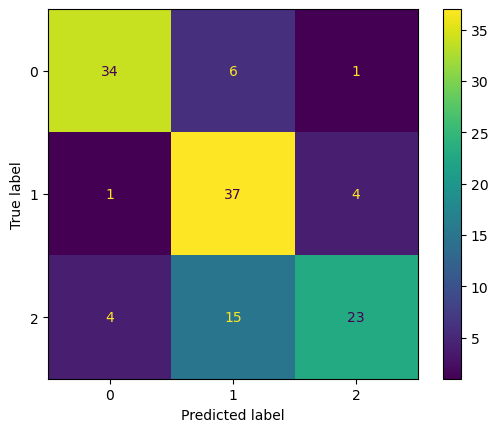

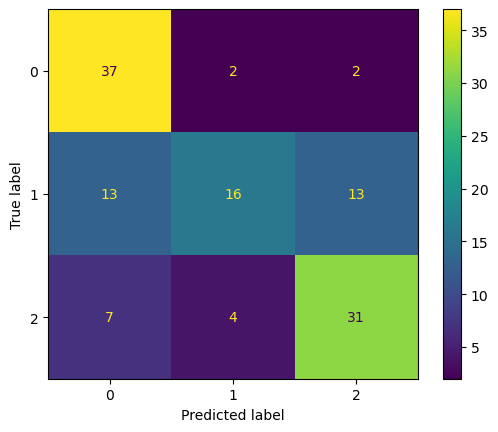

In [20]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

cv = StratifiedKFold(5, shuffle=True, random_state=42)
models = {
    'SVM': (SVC(class_weight='balanced'),{'C':[0.1,1,10],'kernel':['linear','rbf']}),
    'RF': (RandomForestClassifier(class_weight='balanced',random_state=42),{'n_estimators':[100,200],'max_depth':[None,10]}),
    'NB': (GaussianNB(),{})
}

X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

for name,(clf,params) in models.items():
    if params:
        grid = GridSearchCV(clf, params, cv=cv, scoring='f1_macro')
        grid.fit(X_tr2, y_tr2)
        best = grid.best_estimator_
        print(f"{name} best:", grid.best_params_)
    else:
        best = clf.fit(X_tr2, y_tr2)
    pred = best.predict(X_te2)
    print(f"{name} enhanced report:")
    print(classification_report(y_te2, pred))
    ConfusionMatrixDisplay.from_predictions(y_te2, pred)